In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [6]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5504,00030015_000.png,No Finding,0,30015,035Y,M,PA,2021,2021,0.194311,0.194311
3839,00018867_024.png,Edema,24,18867,033Y,F,AP,3056,2544,0.139000,0.139000
4007,00019766_004.png,No Finding,4,19766,037Y,M,PA,2992,2991,0.143000,0.143000


Text(0.5, 1.0, 'View Position Distribution on Original Data')

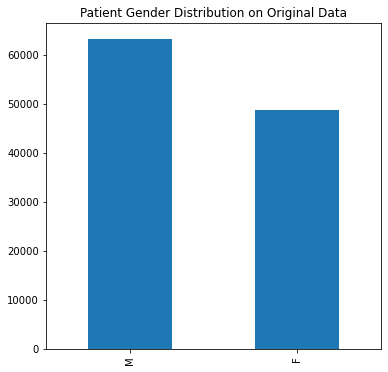

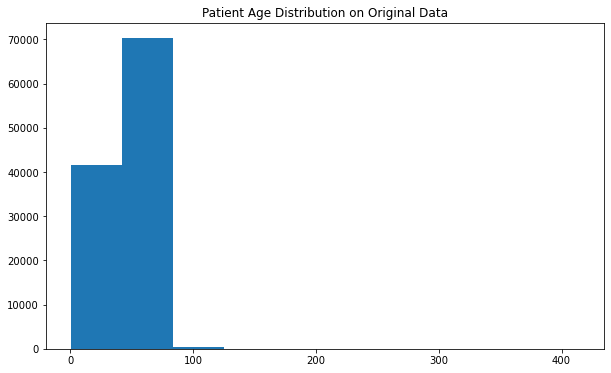

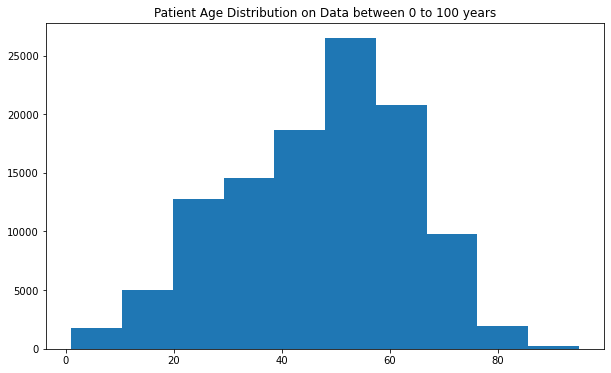

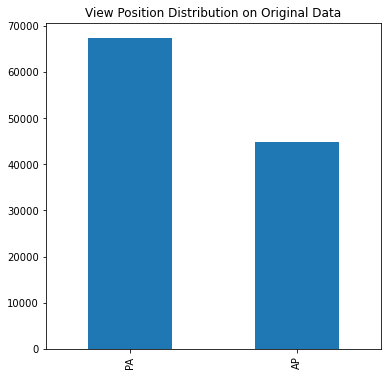

In [3]:
## EDA
# NIH data analysis

# Gender
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Patient Gender Distribution on Original Data')

#Age
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'])
plt.title('Patient Age Distribution on Original Data')

# Seems we have some outliers with age values > 100, so creating filtered version and focus on patients with age <= 120
all_xray_df[all_xray_df['Patient Age'] > 100].head(5)

filtered_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]

plt.figure(figsize=(10,6))
plt.hist(filtered_xray_df['Patient Age'])
plt.title('Patient Age Distribution on Data between 0 to 100 years')

                     
#Patient Position
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')
plt.title('View Position Distribution on Original Data')


Based on the distribution plots above, the following insights can be drawn:

1. **Gender Distribution**: The dataset contains more data points from men. However, there is sufficient data from women as well, which can be utilized for effective model training and optimization.

2. **Patient Age Distribution**: There are noticeable outliers with some patient ages exceeding 150, 200, and even 300. To optimize the model, the focus will be restricted to the age range of 0 to 100.

3. **Patient View Distribution**: The dataset has a higher representation of the PA view compared to the AP view. Nonetheless, there is enough AP data available to contribute effectively to model optimization.


All labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Data Distribution: Pneumonia cases 1431 vs Non-Pneumonia cases 110689


[Text(0, 0.5, 'Number of Images with label')]

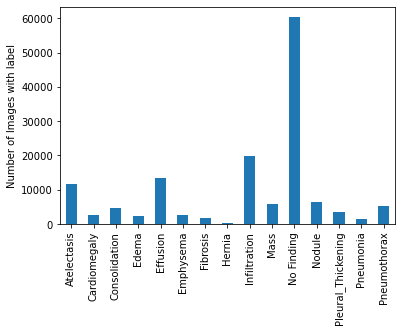

In [4]:
# Split Finding label columns in one additional column per disease
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split("|")).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print(f'All labels ({len(all_labels)}): {all_labels}')

for c_label in all_labels:
    if len(c_label) > 1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0 )

count_pneumonia_cases     = all_xray_df['Pneumonia'].sum()
count_non_pneumonia_cases = all_xray_df.shape[0] - count_pneumonia_cases

print(f'\nData Distribution: Pneumonia cases {count_pneumonia_cases} vs Non-Pneumonia cases {count_non_pneumonia_cases}')


# Analyze and display the distribution across all diseases
all_xray_df[all_labels].sum()/len(all_xray_df)


# Analyze relative frequencies of each disease in the dataset
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = "Number of Images with label")

It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

Since 'Infiltration' is the most common, I'm going to now look at how frequently it appears with all of the other diseases: 

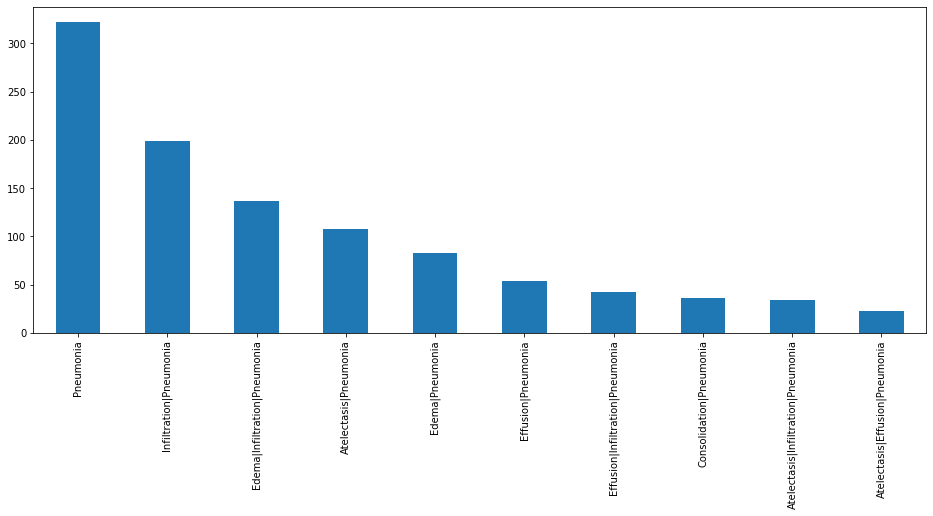

In [5]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:10].plot(kind='bar')

[0.42869982 0.18124626 0.1018574  0.08058718 0.07849011 0.03684841
 0.02127022 0.02097064 0.01437987 0.0122828  0.0122828  0.00689035
 0.00329539 0.00089874]


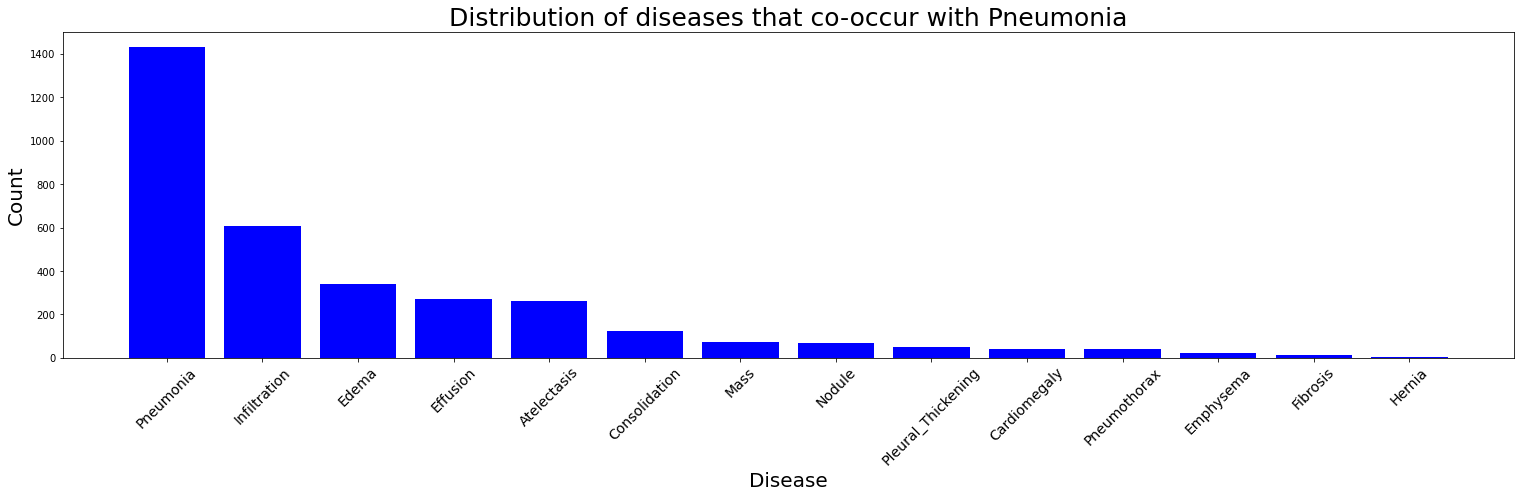

In [11]:
# Number of disease per patient with Pneumonia
disease_per_patient = {}
for c_label in all_labels:
    if c_label != "No Finding":
        disease_per_patient[c_label] = all_xray_df[all_xray_df.Pneumonia==1][c_label].sum()

sorted_disease_per_patient = dict(sorted(disease_per_patient.items(), key=lambda item:item[1], reverse=True))
disease_labels = list(sorted_disease_per_patient.keys())
disease_count = list(sorted_disease_per_patient.values())

# Create a bar plot
plt.figure(figsize=(26,6))
plt.bar(disease_labels, disease_count, color='blue')
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('Disease', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Distribution of diseases that co-occur with Pneumonia', fontsize=25)
plt.show()

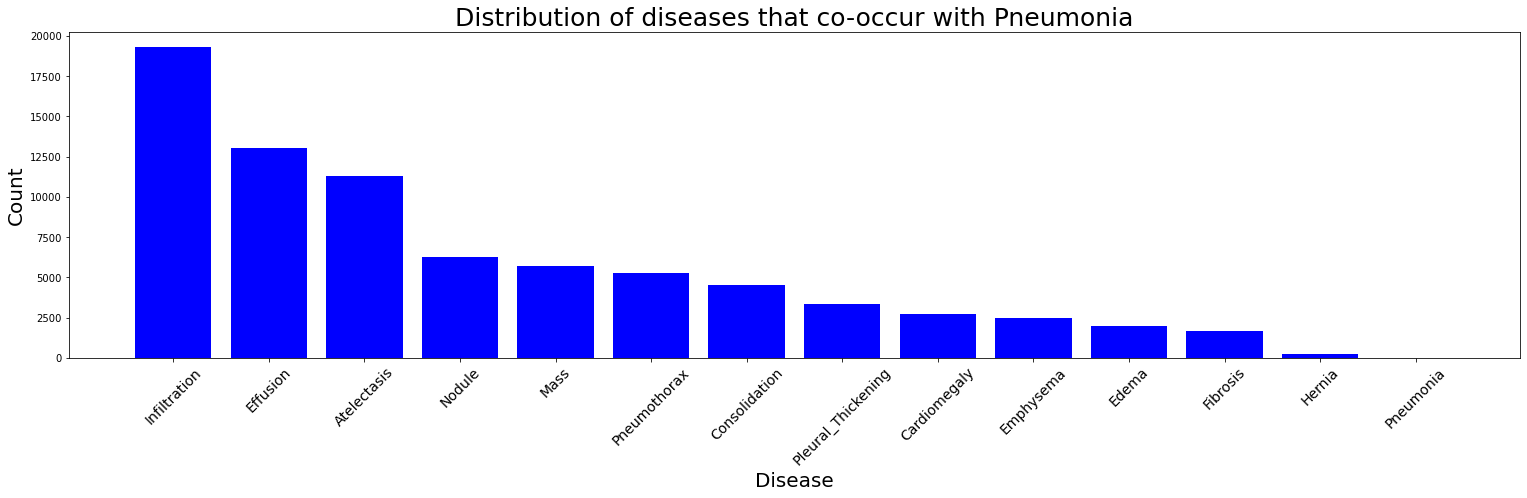

In [9]:
# Number of disease per patient with No Pneumonia
disease_per_patient = {}
for c_label in all_labels:
    if c_label != "No Finding":
        disease_per_patient[c_label] = all_xray_df[all_xray_df.Pneumonia==0][c_label].sum()

sorted_disease_per_patient = dict(sorted(disease_per_patient.items(), key=lambda item:item[1], reverse=True))
disease_labels = list(sorted_disease_per_patient.keys())
disease_count = list(sorted_disease_per_patient.values())

# Create a bar plot
plt.figure(figsize=(26,6))
plt.bar(disease_labels, disease_count, color='blue')
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('Disease', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Distribution of diseases that co-occur with Pneumonia', fontsize=25)
plt.show()

Based on the above plot of diseases that co-occur with Pneumonia, the most commonly observed conditions are Infiltration, Effusion, Atelectasis, Nodule, and Mass. It is crucial to maintain this balance in the training dataset to ensure effective model performance. Efforts should be made to preserve this distribution throughout the training process. 

Let's now delve into pixel-level assessments for these various disease types.

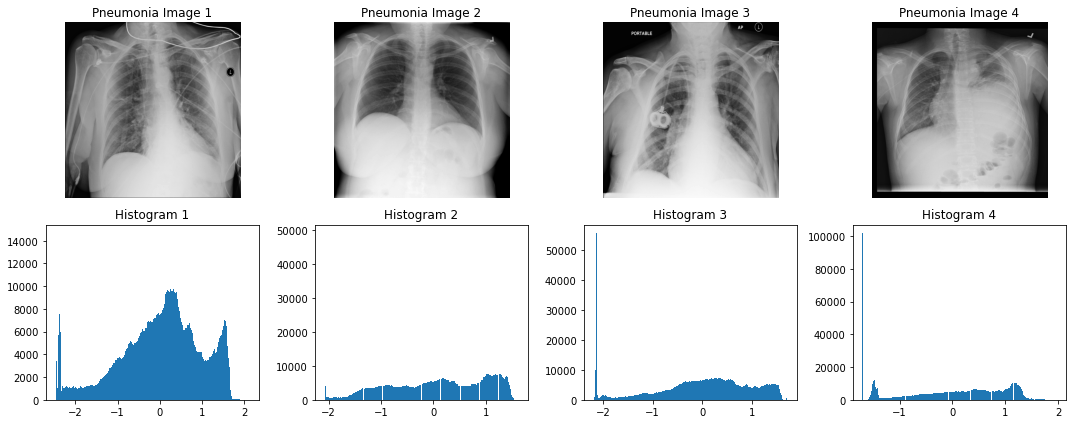

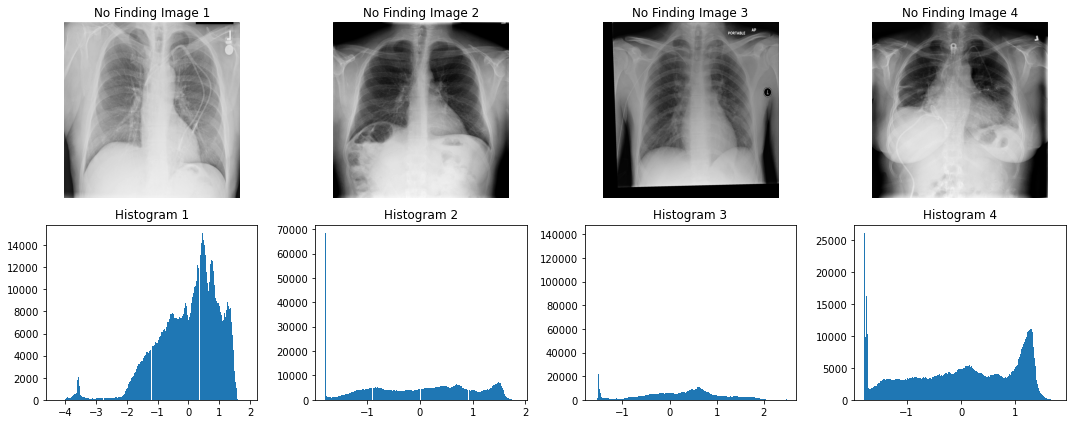

In [7]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

for c_label in all_labels:
    if len(c_label) > 1:
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0 )

# Function to plot images and histograms
def plot_images_and_histograms(df, disease_type, column_name, sample_size, random_state=42):
    """
    Plots images and histograms based on a condition.
    
    Parameters:
    - df: DataFrame containing the data.
    - disease_type: The diease type for filtering condition for selecting rows.
    - column_name: The column with the image paths.
    - sample_size: Number of samples to select.
    - random_state: Random seed for reproducibility.
    """
    # Filter and sample the data
    cases = df[sample_df[disease_type] == 1].sample(n=sample_size, random_state=random_state)[column_name]
    
    # Create subplots
    fig, axes = plt.subplots(2, sample_size, figsize=(15, 6))
    
    # Loop through the sampled images
    for i in range(len(cases)):
        img = plt.imread(cases.iloc[i])  # Read the image
        
        # Plot the image
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'{disease_type} Image {i+1}')
        axes[0, i].axis('off')
        
        # Plot the histogram
        axes[1, i].hist(((img - np.mean(img))/np.std(img)).ravel(), bins=256)
        axes[1, i].set_title(f'Histogram {i+1}')
    
    plt.tight_layout()
    plt.show()

# Plotting Pneumonia cases
plot_images_and_histograms(sample_df, 'Pneumonia', column_name='path_img', sample_size=4)

# Plotting No Finding cases
plot_images_and_histograms(sample_df, 'No Finding', column_name='path_img', sample_size=4)


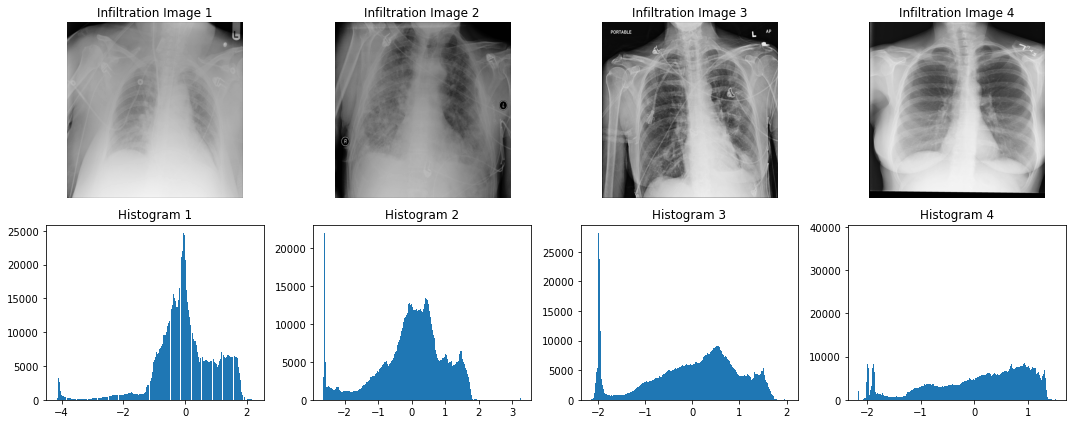

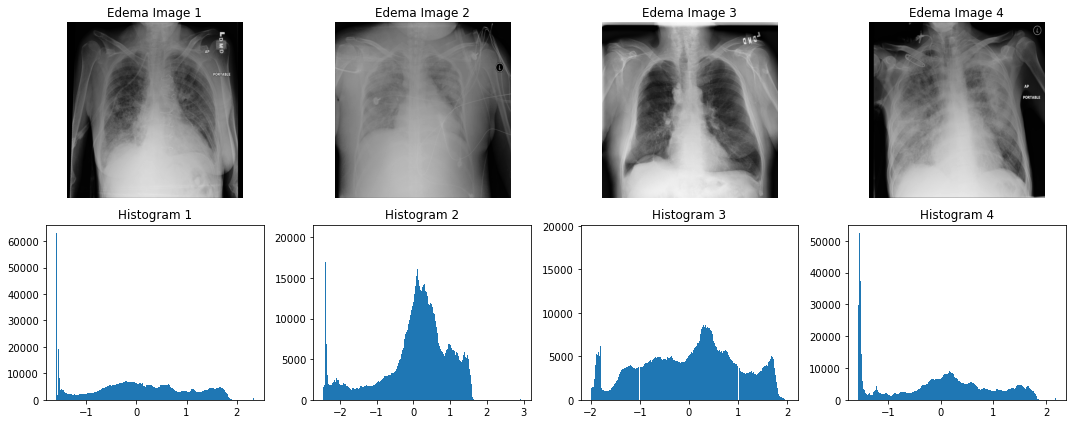

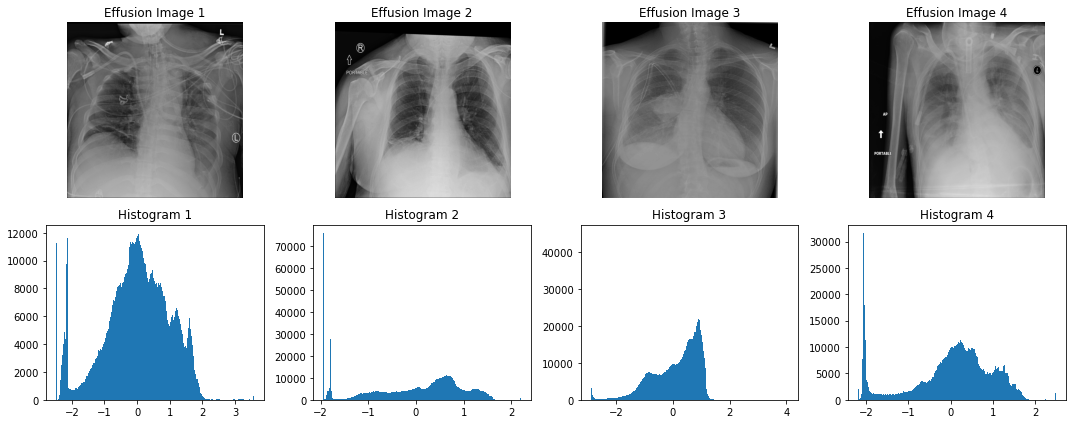

In [18]:
# Plotting Infiltration cases
plot_images_and_histograms(sample_df, 'Infiltration', column_name='path_img', sample_size=4)


# Plotting Edema cases
plot_images_and_histograms(sample_df, 'Edema', column_name='path_img', sample_size=4)


# Plotting Edema cases
plot_images_and_histograms(sample_df, 'Effusion', column_name='path_img', sample_size=4)


From these images and histogram plots above, just based on visual inspection it seems really tough to make an accurate assesment. Just based on intensity distibution its not easy to spot if case  has Penumonia, Edema, Effusion or Infiltration. Even for some cases with no finidngs, intensity distribution is not easy to confirm. There w